In [1]:
import torch

from data_processing.prepare_data import prepare_inference_input
from model.transformer import TransformerTimeSeriesModel

import pandas as pd



In [2]:
# Step 2: Initialize and load Transformer model
input_size = 8
d_model = 128
nhead = 4
num_layers = 6
output_size = 30
model_path = "../models/Transformer_2d3da52c42714d09966f4533c87c490c.pth"

model = TransformerTimeSeriesModel(input_size, d_model, nhead, num_layers, output_size)
model.load_state_dict(torch.load(model_path))
model.eval()


/var/folders/_l/lg0zz1ln2_z8ct4p275jp5880000gn/T/ipykernel_39507/1963945222.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

TransformerTimeSeriesModel(
  (input_layer): Linear(in_features=8, out_features=128, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, o

In [3]:
# Step 3: Perform predictions on historical data
from data_processing.prepare_data import INPUT_VAR



# Step 4: Load historical test data for backtesting
merged_data_path = "../data/processed/merged_data.csv"
test_data = pd.read_csv(merged_data_path)  # Use corresponding test data rows
price_data = test_data["Price"].values  # 종가 데이터
feature_data = test_data[INPUT_VAR].values  # 특성 데이터
date_data = test_data["Date"].values  # 날짜 데이터


In [4]:
# Step 5: Run backtest
from backtest.backtest import backtest, plot_backtest


# 백테스트 실행
n_steps = 30  # 시퀀스 길이
results, total_return, final_value, trades = backtest(
    model=model,
    price_data=price_data,
    feature_data=feature_data,
    date_data=date_data,
    n_steps=n_steps,
    initial_balance=10000,
    transaction_cost=0.001,
)

# 결과 출력
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Final Portfolio Value: ${final_value:.2f}")
print("\nTrade Details:")
print(trades)


Normalized Avg Signal: 0.020833
Normalized Avg Signal: 0.027083
Normalized Avg Signal: 0.012500
Normalized Avg Signal: -0.025000
Normalized Avg Signal: -0.004167
Normalized Avg Signal: -0.006250
Normalized Avg Signal: 0.000000
Normalized Avg Signal: -0.004167
Normalized Avg Signal: 0.004167
Normalized Avg Signal: 0.000000
Normalized Avg Signal: 0.008333
Normalized Avg Signal: -0.025000
Normalized Avg Signal: 0.027083
Normalized Avg Signal: 0.039583
Normalized Avg Signal: 0.016667
Normalized Avg Signal: 0.043750
Normalized Avg Signal: -0.010417
Normalized Avg Signal: 0.004167
Normalized Avg Signal: 0.025000
Normalized Avg Signal: 0.027083
Normalized Avg Signal: 0.039583
Normalized Avg Signal: -0.012500
Normalized Avg Signal: 0.025000
Normalized Avg Signal: 0.010417
Normalized Avg Signal: -0.002083
Normalized Avg Signal: 0.010417
Normalized Avg Signal: 0.010417
Normalized Avg Signal: 0.008333
Normalized Avg Signal: -0.020833
Normalized Avg Signal: -0.004167
Normalized Avg Signal: 0.00416

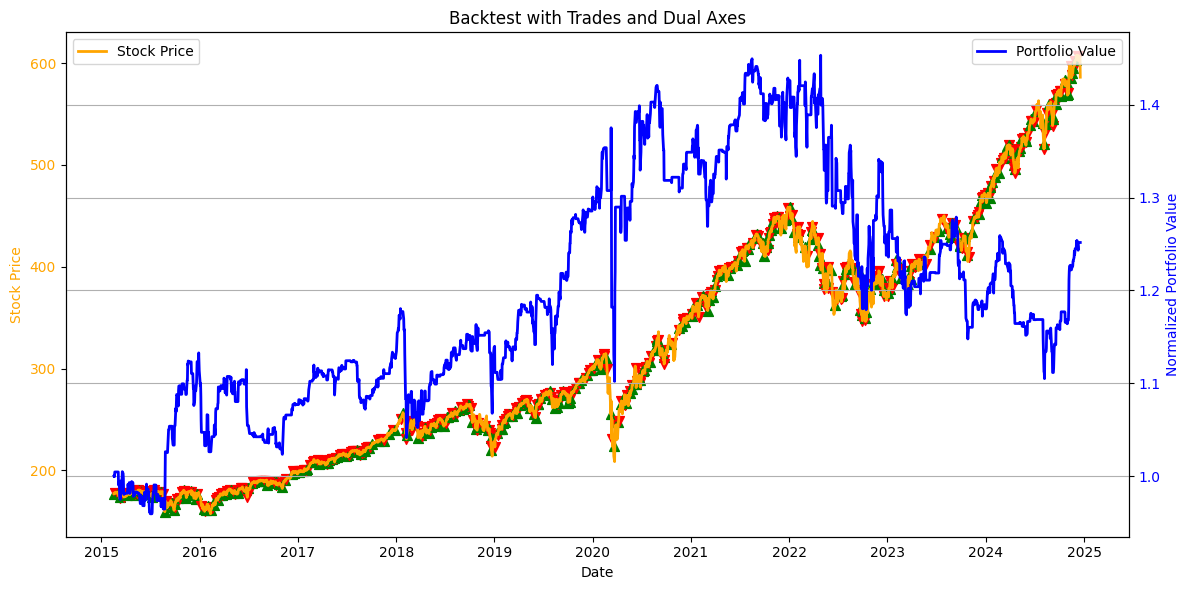

In [ ]:
# 백테스트 결과 시각화 (이중 축, 비율 스케일링)
from matplotlib import pyplot as plt
import pandas as pd

"""
백테스트 결과 시각화 (포트폴리오 가치와 주가 가격을 스케일링하여 비교).
:param results: 백테스트 결과 DataFrame
"""
fig, ax1 = plt.subplots(figsize=(12, 6))

# 첫 번째 축: 주가
normalized_price = results["Price"]
ax1.plot(results["Date"], normalized_price, label="Stock Price", color="orange", linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")
ax1.legend(loc="upper left")

# 두 번째 축: 포트폴리오 가치 (주가 스케일에 맞춤)
initial_price = normalized_price.iloc[0]
scaled_portfolio = results["Portfolio Value"] / results["Portfolio Value"].iloc[0] * initial_price
ax2 = ax1.twinx()
ax2.plot(results["Date"], scaled_portfolio, label="Portfolio Value", color="blue", linewidth=2)
ax2.set_ylabel("Portfolio Value (Scaled)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.legend(loc="upper right")

# 거래 마커
buy_label_shown = False
sell_label_shown = False
for _, trade in trades.iterrows():
    color = "green" if trade["Type"] == "BUY" else "red"
    marker = "^" if trade["Type"] == "BUY" else "v"
    if trade["Type"] == "BUY" and not buy_label_shown:
        ax1.scatter(trade["Date"], trade["Price"], color=color, s=50, marker=marker, label="BUY")
        buy_label_shown = True
    elif trade["Type"] == "SELL" and not sell_label_shown:
        ax1.scatter(trade["Date"], trade["Price"], color=color, s=50, marker=marker, label="SELL")
        sell_label_shown = True
    else:
        ax1.scatter(trade["Date"], trade["Price"], color=color, s=50, marker=marker)

# 시각화 설정
plt.title("Backtest with Trades and Scaled Portfolio Value")
fig.tight_layout()
plt.grid()
plt.show()
